# WNBA Playoffs Prediction
This notebook contains all the steps from data preparation to modeling and evaluation

In [1]:
import os
import pandas as pd
import scripts.utils as utils
import scripts.cleaning as cleaning
import scripts.visualizations as splot
import scripts.processing as processing

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# Load data -dictionary of dataframes
df_data = utils.load_data()
df_final = pd.DataFrame()

## Data Cleaning Process

Our data cleaning process involves several steps to prepare the data for modeling, the funtions used for this project are contained in `scripts/cleaning.py`. There you can check, more detailed, what is being done but in general consists in the following steps.
   - Remove columns that are not needed for our goal or if they are just noise.
   - Sort the DataFrame by relevant columns (e.g., `year`, `playerID`, `stint`) to ensure the data is in a logical order for further processing.
   - Convert categorical values to numerical values for easier analysis and modeling.
   - convert categorical data into numerical format to better fit the algorithms requirements.
   - Create new columns based on existing data to provide additional insights.
   - Aggregate some information to have less features for training, reducing data dimensionality such as win rates..
   - Combine multiple DataFrames to create a comprehensive dataset that includes all relevant information.

In [ ]:
df_data['teams'] = cleaning.clean_teams(df_data['teams'])
df_data['players'] = cleaning.clean_merge_players(df_data['players'], df_data['players_teams'])
df_data['coaches'] = cleaning.clean_coaches(df_data['coaches'])

## Data Processing

We Will start to analyze first the players, since we have a lot of statistics of achivements of the players, we found usefull to separate and agregatte these items of what a player offered and can offer according to his position in the game. we developed a small heuristic to rate the players per year/stint.

In [4]:
print(f"Unique Postions:\n{df_data['players']['pos'].unique()} \nAttributes:\n{df_data['players'].columns}")

Unique Postions:
['G' 'F' 'C' 'G-F' 'F-C' 'C-F' 'F-G'] 
Attributes:
Index(['playerID', 'year', 'stint', 'tmID', 'GP', 'GS', 'minutes', 'points',
       'oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals', 'blocks',
       'turnovers', 'PF', 'fgAttempted', 'fgMade', 'ftAttempted', 'ftMade',
       'threeAttempted', 'threeMade', 'dq', 'PostGP', 'PostGS', 'PostMinutes',
       'PostPoints', 'PostoRebounds', 'PostdRebounds', 'PostRebounds',
       'PostAssists', 'PostSteals', 'PostBlocks', 'PostTurnovers', 'PostPF',
       'PostfgAttempted', 'PostfgMade', 'PostftAttempted', 'PostftMade',
       'PostthreeAttempted', 'PostthreeMade', 'PostDQ', 'pos', 'height',
       'weight', 'college', 'collegeOther', 'birthDate'],
      dtype='object')


In basketball, a player's role is largely determined by their position, which influences their contribution on the court. Our heuristic separates players into the five positional categories that exists in the dataset. Weights were also applied for specific attributes.

1. **Guards (G)**: Playmakers and Perimeter Scorers
   - **Role**: Guards typically control the game flow, create scoring opportunities, and shoot from the perimeter.
   - **Key Attributes**:
     - **Points**: Guards often score from outside, requiring a high weight for points scored.
     - **Assists**: As primary ball handlers, they facilitate scoring for teammates, making assists a critical metric.
     - **Steals**: Guards pressure opponents on defense, and steals highlight their ability to disrupt plays.
     - **Three-pointers Made**: Guards frequently take and make three-point shots, adding to their offensive value.
     - **Turnovers**: A penalty is applied because guards handle the ball most and are prone to turnovers.

2. **Forwards (F)**: Versatile Scorers and Rebounders
   - **Role**: Forwards bridge the gap between perimeter and interior play. They score, rebound, and contribute defensively.
   - **Key Attributes**:
     - **Points**: Forwards often score efficiently, so points carry a high weight.
     - **Rebounds**: Their size and positioning help them grab rebounds, critical for gaining possessions.
     - **Assists**: Forwards often facilitate offense, especially in transition plays.
     - **Blocks**: Their defensive presence in the paint adds value.
     - **Turnovers**: Penalized but less heavily than guards due to their mixed role.

3. **Centers (C)**: Interior Anchors
   - **Role**: Centers dominate near the basket, excelling in rebounding, shot-blocking, and close-range scoring.
   - **Key Attributes**:
     - **Rebounds**: Centers are crucial for securing offensive and defensive rebounds, so this is heavily weighted.
     - **Points**: Scoring is still vital, particularly in the post, and carries significant weight.
     - **Blocks**: Centers anchor the defense, with shot-blocking being a primary metric.
     - **Turnovers**: Penalized, but less critical than for guards due to lower ball-handling responsibilities.

4. **Hybrid Positions**:
   - **Guard-Forward (G-F)**: Hybrid players combine guard-like playmaking with forward-like scoring and rebounding.
     - Balanced weights reflect their dual role (e.g., scoring, assists, rebounds, and three-pointers).
   - **Forward-Center (F-C)**: Hybrid bigs blend the scoring and rebounding of a forward with the interior defense of a center.
     - Rebounds and points take precedence, while blocks and assists are also weighted.

---

- **Scoring Metrics:**
   - **Points**: Fundamental to all positions, but weights vary by role:
     - Higher for positions expected to score consistently (Guards, Forwards, Centers).
   - **Three-pointers Made**: Unique to perimeter-oriented players (Guards, G-F hybrids).

- **Playmaking Metrics:**
   - **Assists**: Essential for guards who drive the offense and secondary for forwards with facilitation roles.

- **Defensive Metrics:**
   - **Rebounds**: Vital for bigs (Centers, Forwards) who secure possessions, with lesser emphasis for guards.
   - **Steals**: Reflective of guards’ perimeter defensive pressure.
   - **Blocks**: Highlight rim protection, especially for Centers and some Forwards.

- **Turnovers:**
   - Penalized for all positions but weighted higher for guards and playmakers due to their ball-handling duties.

In [5]:
# weights inspired on John Hollinger's Player Efficiency Rating (PER) 
# https://bleacherreport.com/articles/113144-cracking-the-code-how-to-calculate-hollingers-per-without-all-the-mess

# weights = {
#         'points': 85.91,      # Corresponds to FGM
#         'assists': 34.677,    # Assists weight
#         'steals': 53.897,     # Steals weight
#         'threeMade': 51.757,  # Three-pointers weight
#         'rebounds': 53.897,   # Combined offensive + defensive rebounds
#         'blocks': 39.19,      # Blocks weight
#         'turnovers': -53.897  # Turnovers weight
#     }

weights = {
        'points': 1,      # Corresponds to FGM
        'assists': 1,    # Assists weight
        'steals': 1,     # Steals weight
        'threeMade': 1,  # Three-pointers weight
        'rebounds': 1,   # Combined offensive + defensive rebounds
        'blocks': 1,      # Blocks weight
        'turnovers': 1  # Turnovers weight
    }


df_data['players']['RegularScore'] = df_data['players'].apply(lambda row: processing.calculate_regular_season_score(row, weights), axis=1)

# same logic but dived my number of minutes played, since the post season is shorter
df_data['players']['PostseasonScore'] = df_data['players'].apply(processing.calculate_postseason_score, axis=1)

df_data['players'] = df_data['players'].drop(columns=['oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals', 'blocks', 
                                                            'turnovers', 'PF', 'fgAttempted', 'fgMade', 'ftAttempted', 'ftMade', 
                                                            'threeAttempted', 'threeMade', 'dq', 'PostGP', 'PostGS', 'PostMinutes', 
                                                            'PostPoints', 'PostoRebounds', 'PostdRebounds', 'PostRebounds', 
                                                            'PostAssists', 'PostSteals', 'PostBlocks', 'PostTurnovers', 'PostPF', 
                                                            'PostfgAttempted', 'PostfgMade', 'PostftAttempted', 'PostftMade', 
                                                            'PostthreeAttempted', 'PostthreeMade', 'PostDQ'])

# View the results
print(df_data['players'][['playerID', 'pos', 'RegularScore', 'PostseasonScore']])



        playerID pos  RegularScore  PostseasonScore
0     aldrima01w   G         25.90         0.123469
1     anderke01w   G         42.00         0.048333
2     andrame01w   F        134.00         0.090361
3     arcaija01w   G         99.85         0.093035
4     askamma01w   C        182.00         0.000000
...          ...  ..           ...              ...
1871  wyckobr01w   F         59.10         0.000000
1872  youngso01w   F        283.80         0.273437
1873  youngta01w   F         15.35         0.000000
1874  youngta01w   F         27.75         0.000000
1875  zellosh01w   G        137.25         0.196207

[1875 rows x 4 columns]


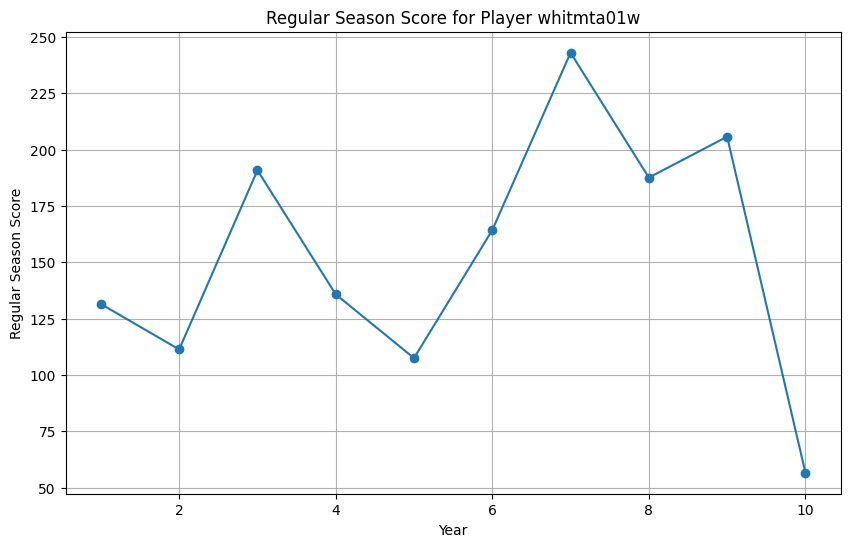

In [6]:
splot.plot_player_regular_score('whitmta01w', df_data['players'])

We find it usefull to create a new attribute with the mean of this heuristic score by team in a certain year/stint.

In [7]:
df_data['players']['TeamScore'] = df_data['players'].apply(lambda row: processing.calculate_team_score(row, df_data['players']), axis=1)

In [8]:
# calculate the average of the score difference to check what players are underperforming or overperforming in their teams

df_data['players']['ScoreDiff'] = df_data['players']['RegularScore'] - df_data['players']['TeamScore']

average_score_diff = df_data['players']['ScoreDiff'].mean(skipna=True)
print(average_score_diff)

# PRINT THE LOWEST SCORE DIFFERENCE

print(df_data['players']['ScoreDiff'].min())

# PRINT THE HIGHEST SCORE DIFFERENCE

print(df_data['players']['ScoreDiff'].max())

positive_mean = df_data['players'].loc[df_data['players']['ScoreDiff'] > 0, 'ScoreDiff'].mean()
positive_count = df_data['players'].loc[df_data['players']['ScoreDiff'] > 0, 'ScoreDiff'].count()
negative_mean = df_data['players'].loc[df_data['players']['ScoreDiff'] < 0, 'ScoreDiff'].mean()
negative_count = df_data['players'].loc[df_data['players']['ScoreDiff'] < 0, 'ScoreDiff'].count()

print("Mean of positive ScoreDiff values:", positive_mean)
print("Number of positive ScoreDiff values:", positive_count)
print()
print("Mean of negative ScoreDiff values:", negative_mean)
print("Number of negative ScoreDiff values:", negative_count)

-1.920627964427893
-109.89347826086954
282.9214285714285
Mean of positive ScoreDiff values: 72.16876384781322
Number of positive ScoreDiff values: 746

Mean of negative ScoreDiff values: -50.876063121143446
Number of negative ScoreDiff values: 1129


In [9]:
df_data['players'].head()

,playerID,year,stint,tmID,GP,GS,minutes,points,pos,height,weight,college,collegeOther,birthDate,RegularScore,PostseasonScore,TeamScore,ScoreDiff
0,aldrima01w,1,0,WAS,29,0,272,63,G,71.0,153,UNC Charlotte,NaN,1973,25.90,0.123469,82.794231,-56.894231
1,anderke01w,1,0,WAS,30,9,434,75,G,67.0,125,Wisconsin,NaN,1974,42.00,0.048333,82.794231,-40.794231
2,andrame01w,1,0,CLE,32,18,797,265,F,71.0,165,Old Dominion,NaN,1975,134.00,0.090361,84.888000,49.112000
3,arcaija01w,1,0,HOU,32,32,977,268,G,71.0,147,none,NaN,1969,99.85,0.093035,86.637500,13.212500
4,askamma01w,1,0,MIA,32,32,869,251,C,77.0,198,none,NaN,1970,182.00,0.000000,61.694000,120.306000


In [10]:
df_data['players'] = processing.predict_heuristic_next(df_data['players'])
df_data['players'] = df_data['players'].drop(columns=[
    'avg_points_last_3_years', 'avg_minutes_last_3_years', 'team_avg_score',
    'pos_C', 'pos_C-F', 'pos_F', 'pos_F-C', 'pos_F-G', 'pos_G', 'pos_G-F',
    'predict_score'
    ])
df_data['players'].head()

Mean Squared Error: 391.17472471368376


,playerID,year,stint,tmID,GP,GS,minutes,points,pos,height,weight,college,collegeOther,birthDate,RegularScore,PostseasonScore,TeamScore,ScoreDiff,RegularScore_next_year
0,aldrima01w,1.0,0.0,WAS,29.0,0.0,272.0,63.0,G,71.0,153.0,UNC Charlotte,0,1973.0,25.90,0.123469,82.794231,-56.894231,2.20
1,anderke01w,1.0,0.0,WAS,30.0,9.0,434.0,75.0,G,67.0,125.0,Wisconsin,0,1974.0,42.00,0.048333,82.794231,-40.794231,6.60
2,andrame01w,1.0,0.0,CLE,32.0,18.0,797.0,265.0,F,71.0,165.0,Old Dominion,0,1975.0,134.00,0.090361,84.888000,49.112000,97.25
3,arcaija01w,1.0,0.0,HOU,32.0,32.0,977.0,268.0,G,71.0,147.0,none,0,1969.0,99.85,0.093035,86.637500,13.212500,207.80
4,askamma01w,1.0,0.0,MIA,32.0,32.0,869.0,251.0,C,77.0,198.0,none,0,1970.0,182.00,0.000000,61.694000,120.306000,61.95


In [11]:
# Calculate a mean of next year heuristic score by team
df_data['players']['predict_team_score'] = df_data['players'].apply(lambda row: processing.calculate_predict_team_score(row, df_data['players']), axis=1)
df_data['players']['teamScore_post'] = df_data['players'].apply(lambda row: processing.calculate_teamScore_post(row, df_data['players']), axis=1)

### Awards
Just count the awards of a team or player in that year.
When passing to the teams, then count all of thar awards of the elements of that teams,

In [12]:
df_data['players'], df_data['coaches'] = processing.merge_awards(df_data['players'], df_data['coaches'], df_data['awards'])

In [13]:
df = df_data['players']
df


,playerID,year,stint,tmID,GP,GS,minutes,points,pos,height,...,collegeOther,birthDate,RegularScore,PostseasonScore,TeamScore,ScoreDiff,RegularScore_next_year,predict_team_score,teamScore_post,awards
0,aldrima01w,1.0,0.0,WAS,29.0,0.0,272.0,63.0,G,71.0,...,0,1973.0,25.90,0.123469,82.794231,-56.894231,2.20000,73.707212,0.088193,0
1,anderke01w,1.0,0.0,WAS,30.0,9.0,434.0,75.0,G,67.0,...,0,1974.0,42.00,0.048333,82.794231,-40.794231,6.60000,73.707212,0.088193,0
2,andrame01w,1.0,0.0,CLE,32.0,18.0,797.0,265.0,F,71.0,...,0,1975.0,134.00,0.090361,84.888000,49.112000,97.25000,71.813212,0.160087,0
3,arcaija01w,1.0,0.0,HOU,32.0,32.0,977.0,268.0,G,71.0,...,0,1969.0,99.85,0.093035,86.637500,13.212500,207.80000,90.792292,0.102744,0
4,askamma01w,1.0,0.0,MIA,32.0,32.0,869.0,251.0,C,77.0,...,0,1970.0,182.00,0.000000,61.694000,120.306000,61.95000,51.015962,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1871,youngso01w,10.0,0.0,SAS,33.0,33.0,1113.0,600.0,F,73.0,...,0,1983.0,283.80,0.273437,123.322222,160.477778,249.49725,113.911889,0.155191,0
1872,youngta01w,10.0,1.0,ATL,11.0,0.0,73.0,30.0,F,74.0,...,0,1986.0,15.35,0.000000,115.343478,-99.993478,27.75000,97.056577,0.133006,0
1873,youngta01w,10.0,2.0,CHI,10.0,6.0,129.0,50.0,F,74.0,...,0,1986.0,27.75,0.000000,103.930682,-76.180682,36.04800,89.962187,0.000000,0
1874,zellosh01w,10.0,0.0,DET,34.0,4.0,802.0,406.0,G,70.0,...,0,1986.0,137.25,0.196207,65.450000,71.800000,126.18525,78.819347,0.098996,0


In [14]:
df.columns

Index(['playerID', 'year', 'stint', 'tmID', 'GP', 'GS', 'minutes', 'points',
       'pos', 'height', 'weight', 'college', 'collegeOther', 'birthDate',
       'RegularScore', 'PostseasonScore', 'TeamScore', 'ScoreDiff',
       'RegularScore_next_year', 'predict_team_score', 'teamScore_post',
       'awards'],
      dtype='object')

### Merging

In [15]:
df_final = df_data['teams'].copy()

df_final = processing.merge_players(df_final, df_data['players'])
df_final = processing.merge_coaches(df_final, df_data['coaches'])

df_final.head()

,year,tmID,confID,rank,playoff,firstRound,semis,finals,min,attend,...,Heuristic_Score,team_predict_mean,team_post_mean,teamScore_mean,awards_players,coaches_win_rate,coaches_post,coaches_history,coaches_history_pos,awards_coach
0,1,CLE,1,2,1,1.0,0.0,-1.0,6500,137532,...,0.536759,71.813212,0.160087,84.888000,1.0,53.125,50.0,53.125,50.0,0.0
1,1,SEA,0,8,0,-1.0,-1.0,-1.0,6475,142594,...,0.483804,58.314339,0.000000,64.157692,0.0,18.750,0.0,18.750,0.0,0.0
2,1,POR,0,7,0,-1.0,-1.0,-1.0,6525,133076,...,0.505867,67.670521,0.000000,84.037500,0.0,31.250,0.0,31.250,0.0,0.0
3,1,SAC,0,3,1,0.0,-1.0,-1.0,6400,126841,...,0.558310,84.777021,0.131097,89.570833,0.0,65.625,0.0,65.625,0.0,0.0
4,1,PHO,0,4,1,0.0,-1.0,-1.0,6425,161075,...,0.554326,70.273071,0.097993,77.451786,0.0,62.500,0.0,62.500,0.0,0.0


In [16]:
df_final = processing.calculate_last_3_years_history(df_final)

# Training

Defining the target value as playoff_next_season

In [17]:
df_final = df_final.sort_values(['tmID', 'year'])

df_final['playoff_next_season'] = df_final.groupby('tmID')['playoff'].shift(-1)

df_final['playoff_next_season'] = df_final.apply(
    lambda row: row['playoff_next_season'] if row['year'] == 10 else (0 if pd.isna(row['playoff_next_season']) else row['playoff_next_season']),
    axis=1
)

Defining the features to be used by the model

In [18]:
features = [
    'year', 'tmID', 'confID', 'rank', 'playoff', 'firstRound', 'semis', 'finals', 'min', 'attend',
    'win_rate', 'homeWin_rate', 'awayWin_rate', 'confW_rate', 'Offensive_Score', 'Defensive_Score',
    'Heuristic_Score', 'last_3_years_history','team_predict_mean','team_post_mean', 
    'teamScore_mean', 'awards_players', 'coaches_win_rate', 'coaches_post', 'coaches_history',
    'coaches_history_pos', 'awards_coach'
    ]
target = 'playoff_next_season'

Choosing the alghoritm

In [64]:
# Train-test split
train_data = df_final[df_final['year'] < 8]
test_data = df_final[df_final['year'] == 8]


X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

categorical_features = ['tmID', 'confID']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Keep other features as is
)

#Build pipeline with preprocessing and classifier
clf = Pipeline(steps=[
   ('preprocessor', preprocessor),
   ('classifier', RandomForestClassifier(random_state=42))
])

#Train the Model
clf.fit(X_train, y_train)

/home/francisco/pythonEnv/ml/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1624: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['tmID', 'confID'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

Predicting and evaluating:

In [65]:
# Predict on the test data using the pipeline
test_data['predicted_playoff_next_season'] = clf.predict(X_test)

# Use the pipeline to calculate probabilities
probas = clf.predict_proba(X_test)[:, 1]  # Get probabilities for class 1
test_data['playoff_probability'] = probas

# Ensure the top 8 teams are selected for playoffs
test_data = test_data.sort_values(by='playoff_probability', ascending=False)

# Assign playoff decision
test_data['final_playoff_decision'] = 0
test_data.iloc[:8, test_data.columns.get_loc('final_playoff_decision')] = 1

# Final output
output = test_data[['tmID', 'year', 'predicted_playoff_next_season', 'final_playoff_decision', 'playoff_probability']]
print(output)

    tmID  year  predicted_playoff_next_season  final_playoff_decision  \
105  DET     8                            1.0                       1   
110  PHO     8                            1.0                       1   
107  IND     8                            1.0                       1   
109  SEA     8                            1.0                       1   
112  CON     8                            1.0                       1   
114  SAC     8                            1.0                       1   
108  SAS     8                            1.0                       1   
104  LAS     8                            1.0                       1   
113  CHI     8                            1.0                       0   
106  NYL     8                            1.0                       0   
103  MIN     8                            0.0                       0   
102  HOU     8                            0.0                       0   
111  WAS     8                            0.0      

/tmp/ipykernel_536851/2139842171.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_playoff_next_season'] = clf.predict(X_test)
/tmp/ipykernel_536851/2139842171.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['playoff_probability'] = probas


In [66]:
# I want to compare now the final_playoff_decision with the playoff_next_season

# Calculate the accuracy of the playoff prediction
accuracy = (test_data['playoff_next_season'] == test_data['final_playoff_decision']).mean()
# Iterate through rows and use the `team` variable (a Series for each row)
for _, team in test_data.iterrows():
    print(f" {team['tmID']}: REAL: {team['playoff_next_season']} PRED:  {team['final_playoff_decision']}  -  BOOL: {team['playoff_next_season'] == team['final_playoff_decision']}")

# Display the accuracy
print(f"Accuracy of playoff prediction: {accuracy:.2f}")

 DET: REAL: 1.0 PRED:  1  -  BOOL: True
 PHO: REAL: 0.0 PRED:  1  -  BOOL: False
 IND: REAL: 1.0 PRED:  1  -  BOOL: True
 SEA: REAL: 1.0 PRED:  1  -  BOOL: True
 CON: REAL: 1.0 PRED:  1  -  BOOL: True
 SAC: REAL: 1.0 PRED:  1  -  BOOL: True
 SAS: REAL: 1.0 PRED:  1  -  BOOL: True
 LAS: REAL: 1.0 PRED:  1  -  BOOL: True
 CHI: REAL: 0.0 PRED:  0  -  BOOL: True
 NYL: REAL: 1.0 PRED:  0  -  BOOL: False
 MIN: REAL: 0.0 PRED:  0  -  BOOL: True
 HOU: REAL: 0.0 PRED:  0  -  BOOL: True
 WAS: REAL: 0.0 PRED:  0  -  BOOL: True
Accuracy of playoff prediction: 0.85


In [67]:
error = abs(test_data['playoff_probability']-test_data['playoff_next_season']).sum()
print(f"Error: {error:.2f}")

Error: 4.60
